In [27]:
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
# !pip install scikit-learn
# !pip install langdetect

# Imports

In [1]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
from plotly.offline import iplot
import re
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import string
import torch
import torch.utils
from torch.utils.data import DataLoader, Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AlbertTokenizer, DistilBertTokenizer, BertTokenizer, AlbertForSequenceClassification, DistilBertForSequenceClassification, BertForSequenceClassification, AdamW
from tqdm.notebook import tqdm


# !nvidia-smi

# Data Preprocessing

In [2]:
full_data = pd.read_csv(r'Datasets\Blog Authorship Corpus\blogtext.csv')
# train_data = pd.read_csv(r"c50.csv")
# test_data = pd.read_csv(r"c50_Test.csv")
# test_data = test_data.drop(test_data.columns[0], axis=1)
# test_data
full_data

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ..."
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i..."
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin..."
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as..."


In [3]:
# cols = list(test_data.columns)
# cols = [cols[-1]] + cols[:-1]
# test_data = test_data.reindex(columns=cols)
# test_data = test_data.rename(columns={'true-author': 'Author'})
# test_data = test_data.drop(columns='ID', axis=1)
# test_data

In [4]:
# full_data = pd.concat([train_data, test_data])
full_data = full_data.rename(columns={'text': 'Text'})
full_data = full_data.rename(columns={'id': 'Author'})

In [5]:
# test_data = test_data.rename(columns={'true-author': 'Author'})
# test_data

In [6]:
# test_data = test_data.drop(columns='ID', axis=1)
# test_data

In [7]:
# full_data = pd.concat([train_data, test_data])
full_data

,Author,gender,age,topic,sign,date,Text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, I could write some really ..."
681280,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, 'I have the second yeast i..."
681281,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan, Your 'boyfriend' is fuckin..."
681282,1713845,male,23,Student,Taurus,"01,July,2004","Dear Susan: Just to clarify, I am as..."


## Text preprocessing

In [8]:
# remove leading and trailing whitespace
# train_data['Text'] = train_data['Text'].str.strip()
# test_data['Text'] = test_data['Text'].str.strip()
full_data['Text'] = full_data['Text'].str.strip()

# # replace multiple spaces with a single space
# train_data['Text'] = train_data['Text'].str.replace(r'\s+', ' ')
# test_data['Text'] = test_data['Text'].str.replace(r'\s+', ' ')
full_data['Text'] = full_data['Text'].str.replace(r'\s+', ' ')


In [9]:
# df = df.drop(df.columns[0], axis=1)
# full_data = full_data.drop(full_data.columns[1:6], axis=1)
# full_data = full_data.rename(columns={'text': 'Text'})
# full_data.head(5)
# test_data = test_data.drop(test_data.columns[0], axis=1)
# test_data
# train_data

In [11]:
# train_data


In [12]:
# lambda function to remove emails
remove_emails = lambda x: re.sub(r'\S+@\S+', '', x)

# lambda function to remove URLs
remove_urls = lambda x: re.sub(r'http\S+', '', x)
# train_data['Text'] = train_data['Text'].apply(remove_emails).apply(remove_urls)
# test_data['Text'] = test_data['Text'].apply(remove_emails).apply(remove_urls)
full_data['Text'] = full_data['Text'].apply(remove_emails).apply(remove_urls)

# Remove unwanted characters and convert to lowercase
# train_data['Text'] = train_data['Text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower()))
# test_data['Text'] = test_data['Text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower()))
full_data['Text'] = full_data['Text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower()))

# print(type(train_data['Text']))

In [13]:
# train_data
full_data

,Author,gender,age,topic,sign,date,Text
0,2059027,male,15,Student,Leo,"14,May,2004",info has been found 100 pages and 45 mb of pd...
1,2059027,male,15,Student,Leo,"13,May,2004",these are the team members drewes van der la...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde maak je e...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoos toolbar i can now capture the...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i could write some really bitter d...
681280,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i have the second yeast infection ...
681281,1713845,male,23,Student,Taurus,"01,July,2004",dear susan your boyfriend is fucking bald go...
681282,1713845,male,23,Student,Taurus,"01,July,2004",dear susan just to clarify i am asking you ...


In [14]:
# # Tokenize the text
# data['text'] = data['text'].apply(lambda x: word_tokenize(x))
# print(type(data['text']))

# Remove stop words
# stop_words = set(stopwords.words('english'))
# remove_stopwords = lambda text: ' '.join([word for word in text.split() if word.lower() not in stop_words])

# data['text'] = data['text'].apply(remove_stopwords)
# print(type(data['text']))

# remove newline characters
# train_data['Text'] = train_data['Text'].str.replace('\n', '')
# test_data['Text'] = test_data['Text'].str.replace('\n', '')
full_data['Text'] = full_data['Text'].str.replace('\n', '')

# # Lemmatize the text
# lemmatizer = WordNetLemmatizer()
# data['text'] = data['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
# print(type(data['text']))

In [15]:
# train_data
# test_data
full_data

,Author,gender,age,topic,sign,date,Text
0,2059027,male,15,Student,Leo,"14,May,2004",info has been found 100 pages and 45 mb of pd...
1,2059027,male,15,Student,Leo,"13,May,2004",these are the team members drewes van der la...
2,2059027,male,15,Student,Leo,"12,May,2004",in het kader van kernfusie op aarde maak je e...
3,2059027,male,15,Student,Leo,"12,May,2004",testing testing
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoos toolbar i can now capture the...
...,...,...,...,...,...,...,...
681279,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i could write some really bitter d...
681280,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i have the second yeast infection ...
681281,1713845,male,23,Student,Taurus,"01,July,2004",dear susan your boyfriend is fucking bald go...
681282,1713845,male,23,Student,Taurus,"01,July,2004",dear susan just to clarify i am asking you ...


In [16]:
word_count_func = lambda x: len(x.split())
# train_data['word_count'] = train_data['Text'].apply(word_count_func)
# test_data['word_count'] = test_data['Text'].apply(word_count_func)
full_data['word_count'] = full_data['Text'].apply(word_count_func)

<Figure size 800x800 with 0 Axes>

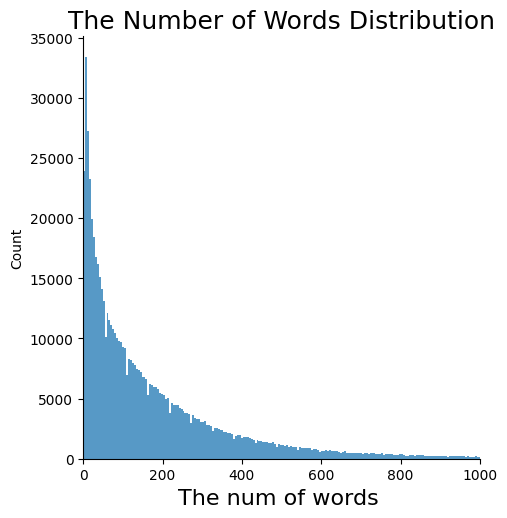

In [17]:
plt.figure(figsize= (8, 8))

sns.displot(full_data['word_count'])

plt.xlim(0, 1000)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

In [18]:
# MAX = full_data['word_count'].max()
# MAX

# Selecting Authors

In [19]:
selected_rows = full_data[(full_data['word_count'] >= 30) & (full_data['word_count'] <= 75)]
# selected_rows = data[(data['word_count'] >= 200) & (data['word_count'] <= 325)]

selected_rows
# full_data

,Author,gender,age,topic,sign,date,Text,word_count
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",thanks to yahoos toolbar i can now capture the...,65
13,3581210,male,33,InvestmentBanking,Aquarius,"09,June,2004",there is so much that is different here from a...,63
33,3581210,male,33,InvestmentBanking,Aquarius,"29,June,2004",i often wondered where the restauranteurs heat...,73
97,3668238,female,17,Student,Gemini,"30,June,2004",my shoes travel far and wide one day i ...,35
108,4030905,female,17,Student,Aries,"30,July,2004",such a boring day i have no comments i found o...,41
...,...,...,...,...,...,...,...,...
681275,1713845,male,23,Student,Taurus,"04,July,2004",dear susan its mom i just got those pictures...,48
681277,1713845,male,23,Student,Taurus,"02,July,2004",dear susan there once was a bird the size of ...,58
681279,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i could write some really bitter d...,40
681280,1713845,male,23,Student,Taurus,"01,July,2004",dear susan i have the second yeast infection ...,65


In [20]:
len(selected_rows['Author'].unique()) 


12083

In [21]:
# from langdetect import detect

# # apply language detection to DataFrame and filter out non-English samples
# df = df[df['Text'].apply(lambda x: detect(x) == 'en' if x else False)]
# # df

In [22]:
#Num of samples per id
counts = selected_rows['Author'].value_counts()
counts

Author
449628     1132
831241      994
1078410     605
942828      570
1270648     562
           ... 
4072007       1
4223598       1
2283243       1
2992515       1
3922561       1
Name: count, Length: 12083, dtype: int64

In [23]:
selected_rows = selected_rows[selected_rows['Author'].isin(counts[(counts >= 300) & (counts <= 425)].index)]
# selected_rows = selected_rows[selected_rows['id'].isin(counts[(counts >= 100) & (counts <= 300)].index)]

len(selected_rows['Author'].value_counts()) #34 authors with 70-95 samples

26

In [24]:
df =selected_rows.reset_index(drop=True)
# df = df.drop('word_count', axis=1)
# df['Text'].iloc[0]

In [25]:
df#['text'][0]

,Author,gender,age,topic,sign,date,Text,word_count
0,883178,male,36,Fashion,Aries,"30,August,2002",highlights no highlights the show sucked so...,62
1,883178,male,36,Fashion,Aries,"28,August,2002",i heard that tonight p diddy is throwing the g...,34
2,883178,male,36,Fashion,Aries,"28,August,2002",dont even try to pretend you dont love it djs ...,62
3,883178,male,36,Fashion,Aries,"27,August,2002",not to worry shovel even the best of us are d...,59
4,883178,male,36,Fashion,Aries,"26,August,2002",urllink urllink which princess bride char...,56
...,...,...,...,...,...,...,...,...
9017,461975,male,25,indUnk,Pisces,"03,August,2004",no i havent i still need a computer case to ac...,44
9018,461975,male,25,indUnk,Pisces,"03,August,2004",who cleverly resized that image then eh where ...,64
9019,461975,male,25,indUnk,Pisces,"03,August,2004",tom i sent you an invite ages ago to the board...,48
9020,461975,male,25,indUnk,Pisces,"02,August,2004",ok point taken i will try and use youryoure i...,39


In [26]:
min_samples = df['Author'].value_counts().min()
print(min_samples)
df_balanced = df.groupby('Author').apply(lambda x: x.sample(min_samples)).reset_index(drop=True)
df_balanced

301


,Author,gender,age,topic,sign,date,Text,word_count
0,49663,male,33,indUnk,Taurus,"26,April,2001",i am going into the studio tonight for the fir...,59
1,49663,male,33,indUnk,Taurus,"31,January,2002",update from the pain management center my ...,43
2,49663,male,33,indUnk,Taurus,"11,October,2000",of dubious debates kisses and divas must we ch...,32
3,49663,male,33,indUnk,Taurus,"08,November,2000",okayso it wasnt a date exactly i had to take h...,44
4,49663,male,33,indUnk,Taurus,"10,April,2001",my friend jennie is now in spain enjoying the ...,33
...,...,...,...,...,...,...,...,...
7821,3585348,male,25,Chemicals,Aquarius,"28,July,2004",dude that sucks it is fricking roasting here ...,46
7822,3585348,male,25,Chemicals,Aquarius,"04,July,2004",the man of steel is also grabbing headlines to...,66
7823,3585348,male,25,Chemicals,Aquarius,"15,June,2004",for the record edonkey2000 came first and conn...,65
7824,3585348,male,25,Chemicals,Aquarius,"03,June,2004",see if you are urllink good at pulling i got ...,56


# Split Data in Half

In [27]:
id_count = df_balanced['Author'].value_counts()
len(id_count)

26

In [28]:
to_remove = id_count[:1].index.tolist()
# new_df = df_balanced
new_df = df_balanced[~df_balanced['Author'].isin(to_remove)]
new_df['Author'].unique()


array([ 105748,  106651,  108212,  240089,  271835,  313102,  320317,
        322624,  461975,  576311,  595404,  655250,  883178,  944569,
        955372, 1157144, 1432406, 1473902, 1784456, 2200026, 2866266,
       3517276, 3522724, 3523319, 3585348], dtype=int64)

In [29]:
# len(new_df['id'].unique())
# # new_df['id'].value_counts()
new_df

,Author,gender,age,topic,sign,date,Text,word_count
301,105748,female,26,Student,Scorpio,"04,July,2004",q what do you call a midget psychic who just c...,54
302,105748,female,26,Student,Scorpio,"04,July,2004",i was just perusing ching and brians blog i a...,62
303,105748,female,26,Student,Scorpio,"04,July,2004",young at heart frank sinatra thanks pia i gu...,58
304,105748,female,26,Student,Scorpio,"04,July,2004",what a slaughter nets win over the pistons 102...,36
305,105748,female,26,Student,Scorpio,"04,July,2004",what kind of design does he have in mind i don...,40
...,...,...,...,...,...,...,...,...
7821,3585348,male,25,Chemicals,Aquarius,"28,July,2004",dude that sucks it is fricking roasting here ...,46
7822,3585348,male,25,Chemicals,Aquarius,"04,July,2004",the man of steel is also grabbing headlines to...,66
7823,3585348,male,25,Chemicals,Aquarius,"15,June,2004",for the record edonkey2000 came first and conn...,65
7824,3585348,male,25,Chemicals,Aquarius,"03,June,2004",see if you are urllink good at pulling i got ...,56


In [30]:
# category_count = df_balanced['id'].value_counts()

category_count = new_df['Author'].value_counts()
categories = category_count.index

len(categories)

25

In [31]:
# fig = plt.figure(figsize= (15, 5))

# ax = fig.add_subplot(111)

# sns.barplot(x = category_count.index, y = category_count )

# for a, p in enumerate(ax.patches):
#     ax.annotate(f'{categories[a]}\n' + format(p.get_height(), '.0f'), xy = (p.get_x() + p.get_width() / 2.0, p.get_height()), xytext = (0,-25), size = 13, color = 'white' , ha = 'center', va = 'center', textcoords = 'offset points', bbox = dict(boxstyle = 'round', facecolor='none',edgecolor='white', alpha = 0.5) )
    
# plt.xlabel('IDs', size = 15)

# plt.ylabel('The Number of Blogs', size= 15)

# plt.xticks(size = 12)

# plt.title("The number of Blogs by ID" , size = 18)

# plt.show()

In [32]:
# df_balanced.to_csv(r'Datasets\Blog Authorship Corpus\balanced_blogtext.csv')

In [33]:
# df_balanced = pd.read_csv(r'Datasets\Blog Authorship Corpus\balanced_blogtext.csv')

# Tokenization

In [34]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',  do_lower_case=True)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',  do_lower_case=True)
# tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2',  do_lower_case=True)

In [35]:
# df_balanced = df_balanced.drop(df_balanced.columns[0], axis=1)
# df_balanced
new_df = new_df.reset_index(drop=True)
new_df
# train_data
# full_data

,Author,gender,age,topic,sign,date,Text,word_count
0,105748,female,26,Student,Scorpio,"04,July,2004",q what do you call a midget psychic who just c...,54
1,105748,female,26,Student,Scorpio,"04,July,2004",i was just perusing ching and brians blog i a...,62
2,105748,female,26,Student,Scorpio,"04,July,2004",young at heart frank sinatra thanks pia i gu...,58
3,105748,female,26,Student,Scorpio,"04,July,2004",what a slaughter nets win over the pistons 102...,36
4,105748,female,26,Student,Scorpio,"04,July,2004",what kind of design does he have in mind i don...,40
...,...,...,...,...,...,...,...,...
7520,3585348,male,25,Chemicals,Aquarius,"28,July,2004",dude that sucks it is fricking roasting here ...,46
7521,3585348,male,25,Chemicals,Aquarius,"04,July,2004",the man of steel is also grabbing headlines to...,66
7522,3585348,male,25,Chemicals,Aquarius,"15,June,2004",for the record edonkey2000 came first and conn...,65
7523,3585348,male,25,Chemicals,Aquarius,"03,June,2004",see if you are urllink good at pulling i got ...,56


In [36]:
# MAX_LENGTH = selected_rows['word_count'].max()
MAX_LENGTH = new_df['word_count'].max()

# df_balanced['encoded_id'] = df_balanced['id'].astype('category').cat.codes
# get unique categories for Author in both dataframes
# categories = pd.Categorical(pd.concat([train_data['Author'], test_data['true-author']], ignore_index=True)).categories
categories = pd.Categorical(new_df['Author']).categories
# categories = pd.Categorical(new_df['id']).categories

# assign categorical variable to both dataframes using the same categories
# train_data['encoded_Author'] = pd.Categorical(train_data['Author'], categories=categories).codes
# test_data['encoded_Author'] = pd.Categorical(test_data['true-author'], categories=categories).codes
# full_data['encoded_Author'] = pd.Categorical(full_data['Author'], categories=categories).codes
new_df['encoded_Author'] = pd.Categorical(new_df['Author'], categories=categories).codes


# Define the training and validation data
# texts = df_balanced['text'].to_list()
# labels = df_balanced['encoded_id'].to_list()

# train_texts = train_data['Text'].to_list()
# train_labels = train_data['encoded_Author'].to_list()

full_texts = new_df['Text'].to_list()
full_labels = new_df['encoded_Author'].to_list()

#split test into test and validation
# test_texts = test_data['Text'].to_list()
# test_labels = test_data['encoded_Author'].to_list()

In [37]:
MAX_LENGTH
new_df
# full_data

,Author,gender,age,topic,sign,date,Text,word_count,encoded_Author
0,105748,female,26,Student,Scorpio,"04,July,2004",q what do you call a midget psychic who just c...,54,0
1,105748,female,26,Student,Scorpio,"04,July,2004",i was just perusing ching and brians blog i a...,62,0
2,105748,female,26,Student,Scorpio,"04,July,2004",young at heart frank sinatra thanks pia i gu...,58,0
3,105748,female,26,Student,Scorpio,"04,July,2004",what a slaughter nets win over the pistons 102...,36,0
4,105748,female,26,Student,Scorpio,"04,July,2004",what kind of design does he have in mind i don...,40,0
...,...,...,...,...,...,...,...,...,...
7520,3585348,male,25,Chemicals,Aquarius,"28,July,2004",dude that sucks it is fricking roasting here ...,46,24
7521,3585348,male,25,Chemicals,Aquarius,"04,July,2004",the man of steel is also grabbing headlines to...,66,24
7522,3585348,male,25,Chemicals,Aquarius,"15,June,2004",for the record edonkey2000 came first and conn...,65,24
7523,3585348,male,25,Chemicals,Aquarius,"03,June,2004",see if you are urllink good at pulling i got ...,56,24


In [96]:
# test_labels[-1]
# test_data

In [38]:
# Check for missing values in the labels
# if df_balanced['encoded_id'].isnull().sum() > 0:
if new_df['encoded_Author'].isnull().sum() > 0:
    print('There are missing values in the labels!')
else:
    print('No missing values in the labels')

No missing values in the labels


In [39]:
# new_df['encoded_id'].unique()
len(new_df['encoded_Author'])
# len(labels)


7525

In [ ]:
len(test_texts)#, len(labels)
# 3432+858

NameError: name 'test_texts' is not defined

In [ ]:
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.1, random_state=42, stratify=labels)
# len(X_train), len(X_test),len(X_train), len(y_test)
X_train = train_texts
y_train = train_labels
len(X_train), len(X_train)

NameError: name 'train_texts' is not defined

In [ ]:
# # Split training set into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
# len(X_train), len(X_val), len(y_train), len(y_val)

# Split unknown set into test and validation sets
X_test, X_val, y_test, y_val = train_test_split(test_texts, test_labels, test_size=0.8, random_state=42, stratify=test_labels)
len(X_test), len(X_val), len(y_test), len(y_val)

NameError: name 'test_texts' is not defined

In [40]:
#FOR FULL_DATA
X = new_df['Text']#.drop(['Author', 'encoded_author'], axis=1)
y = new_df['encoded_Author']

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split train into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)
len(X_train), len(X_test), len(X_val), len(y_train), len(y_test), len(y_val)

(4515, 1505, 1505, 4515, 1505, 1505)

In [ ]:
# y_test =y_test.to_list()

## Encode Function

In [42]:
def encode(docs):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=MAX_LENGTH, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    # inputs_embeds = encoded_dict['inputs_embeds']
    attention_masks = encoded_dict['attention_mask']
    # texts = docs
    # print(encoded_dict)
    return input_ids, attention_masks#, texts
# input_ids, attention_masks = encode(texts)
# labels = torch.tensor(labels)  

In [43]:
train_input_ids, train_att_masks = encode(X_train)
valid_input_ids, valid_att_masks = encode(X_val)
test_input_ids, test_att_masks = encode(X_test)

In [44]:
train_y = torch.LongTensor(y_train.to_list())
valid_y = torch.LongTensor(y_val.to_list())
test_y = torch.LongTensor(y_test.to_list())
train_y.size(),valid_y.size(),test_y.size()
# len(train_y)


(torch.Size([4515]), torch.Size([1505]), torch.Size([1505]))

# Data Loaders

In [45]:
BATCH_SIZE = 25

In [46]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_input_ids, valid_att_masks, valid_y)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_input_ids, test_att_masks, test_y)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [47]:
# Tokenize the training and validation data
# input_ids = []
# attention_masks = []
# for text in texts:
#     encoded_dict = tokenizer.encode_plus(
#                         text,
#                         add_special_tokens = True,
#                         max_length = MAX_LENGTH,
#                         padding=True,
#                         truncation=True,
#                         return_attention_mask = True,
#                         return_tensors = 'pt'
#                    )
#     input_ids.append(encoded_dict['input_ids'])
#     attention_masks.append(encoded_dict['attention_mask'])
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)  

# Model Architecture

In [48]:
# len(df_balanced['id'].unique())
PRETRAINED_LM = "distilbert-base-uncased"#"albert-base-v2"#"bert-base-uncased"
DROPOUT_RATE = 0.1

In [49]:
from torch import nn
N_labels = len(new_df['encoded_Author'].unique())#len(train_data['Author'].unique())#len(df_balanced['id'].unique())#len(new_df['id'].unique())
model = DistilBertForSequenceClassification.from_pretrained(PRETRAINED_LM,
                                                      num_labels=N_labels,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# import torch.nn as nn

# class EmbeddingModel(DistilBertForSequenceClassification):
#     def __init__(self, config):
#         super().__init__(config)
#         self.embeddings = nn.Embedding(config.vocab_size, config.dim, padding_idx=config.pad_token_id)

#     def forward(self, inputs_embeds, **kwargs):
#         inputs = self.embeddings.weight[None, :, :] + inputs_embeds[:, :, None]
#         return super().forward(inputs, **kwargs)

# config = model.config
# new_model = EmbeddingModel(config)
# new_model.classifier = model.classifier

model.dropout = nn.Dropout(DROPOUT_RATE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device                                                      

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

device(type='cuda')

In [50]:
model.to(device)
# new_model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

# FineTuning

## Optimizer and Scheduler

In [60]:
from torch.optim import AdamW, RMSprop, Adam
from transformers import get_linear_schedule_with_warmup

EPOCHS = 30
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0.01
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = get_linear_schedule_with_warmup(optimizer, 
             num_warmup_steps=0,
            num_training_steps=len(train_dataloader)*EPOCHS )

In [61]:
# train_labels

## Training Loop

In [62]:
from torch.nn.utils import clip_grad_norm_
import math

train_loss_per_epoch = []
val_loss_per_epoch = []
best_val_loss = float('inf')

train_accuracy_list = []
valid_accuracy_list = []

# # Load saved model state dict
# checkpoint = torch.load(r'distilbert_finetuned_c50_tfidf\distilbert_finetuned_tfidf_cluster_35.pt')
# #1e-6 -> 1e-5
# model.load_state_dict(checkpoint['model_state_dict'])

# # Load saved optimizer state dict if available
# if 'optimizer_state_dict' in checkpoint:
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


for epoch_num in range(EPOCHS):
    print('Epoch: ', epoch_num + 1)
    '''
    Training
    '''
    model.train()
    train_loss = 0
    train_pred = []
    train_label = []
    for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        # input_embeds=model.get_input_embeddings().weight[input_ids].clone()

        output = model(input_ids = input_ids, attention_mask=att_mask, labels=labels)
        # inputs_embeds = new_model.embeddings(input_ids=input_ids, attention_mask=att_mask)
        # output = model(attention_mask=att_mask, inputs_embeds=input_embeds, labels= labels)
        loss = output.loss
        train_loss += loss.item()
        
        train_pred.append(np.argmax(output.logits.detach().cpu().numpy(),axis=-1))
        train_label.append(labels.detach().cpu().numpy())
        model.zero_grad()
        loss.backward()
        del loss

        clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    train_loss_per_epoch.append(train_loss / (step_num + 1))              
    train_pred = np.concatenate(train_pred)
    train_label = np.concatenate(train_label)
    train_accuracy_per_epoch = (train_pred == train_label).mean()
    train_accuracy_list.append(train_accuracy_per_epoch)
    '''
    Validation
    '''
    model.eval()
    valid_loss = 0
    valid_pred = []
    valid_label = []
    with torch.no_grad():
        for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            # input_embeds=model.get_input_embeddings().weight[input_ids].clone()
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)
            # output = model(attention_mask=att_mask, inputs_embeds=input_embeds, labels= labels)
            loss = output.loss
            valid_loss += loss.item()
   
            valid_pred.append(np.argmax(output.logits.detach().cpu().numpy(),axis=-1))
            valid_label.append(labels.detach().cpu().numpy())
        
    val_loss_per_epoch.append(valid_loss / (step_num_e + 1))
    valid_pred = np.concatenate(valid_pred)
    valid_label = np.concatenate(valid_label)
    valid_accuracy_per_epoch = (valid_pred == valid_label).mean()
    valid_accuracy_list.append(valid_accuracy_per_epoch)

    #Early Stopping
    if (valid_loss / (step_num_e + 1)) < best_val_loss:
        # torch.save(model.state_dict(), f'best_model_epoch{epoch_num+1}.pt')
        best_val_loss = valid_loss
    else:
        break

    # save model checkpoint every 5th epoch
    if (epoch_num + 1) % 5 == 0:
        checkpoint = {
            'epoch': epoch_num + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': valid_loss,
            'val_accuracy': valid_pred,
        }
        # torch.save(checkpoint, fr'distilbert_finetuned_c50_tfidf\distilbert_finetuned_tfidf_{epoch_num+1}.pt')

    '''
    Loss message
    '''
    
    print("{0}/{1} train loss: {2} ".format(step_num+1, math.ceil(len(train_y) / BATCH_SIZE), train_loss / (step_num + 1)))
    print("{0}/{1} val loss: {2} ".format(step_num_e+1, math.ceil(len(valid_y) / BATCH_SIZE), valid_loss / (step_num_e + 1)))
    # print(f"{step_num+1}/{math.ceil(len(train_dataloader))} train loss: {train_loss}".format(step_num+1, math.ceil(len(train_dataloader)) / BATCH_SIZE), train_loss / (step_num + 1))
    # print(f"{step_num_e+1}/{math.ceil(len(valid_dataloader))} val loss: {valid_loss} ")#.format(step_num_e+1, math.ceil(len(valid_dataloader)) / BATCH_SIZE), valid_loss / (step_num_e + 1))

Epoch:  1


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 2.4508332066773053 
61/61 val loss: 2.2647829036243627 
Epoch:  2


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 2.190157643339252 
61/61 val loss: 2.2153875945044343 
Epoch:  3


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 2.0306975340974924 
61/61 val loss: 2.2874747280214653 
Epoch:  4


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.9692661077278095 
61/61 val loss: 2.163753955090632 
Epoch:  5


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.877166505017992 
61/61 val loss: 1.9808133039318148 
Epoch:  6


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.813203927561723 
61/61 val loss: 1.9357443539822687 
Epoch:  7


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.7528274421533827 
61/61 val loss: 1.9665733614905936 
Epoch:  8


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.6793666248163466 
61/61 val loss: 2.0286920793720933 
Epoch:  9


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.6296735475076496 
61/61 val loss: 1.9794065893673507 
Epoch:  10


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.6035139692422435 
61/61 val loss: 1.9542468043624377 
Epoch:  11


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.575851419354012 
61/61 val loss: 1.9283312305075224 
Epoch:  12


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5244150583256675 
61/61 val loss: 1.9849991212125684 
Epoch:  13


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.4975775730544032 
61/61 val loss: 1.9531022114831893 
Epoch:  14


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.4871869930246258 
61/61 val loss: 1.9570749959007638 
Epoch:  15


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.474941920838962 
61/61 val loss: 1.9779781220389194 
Epoch:  16


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.4702209346202197 
61/61 val loss: 1.9792540503329918 
Epoch:  17


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.468529622199127 
61/61 val loss: 1.986764558026048 
Epoch:  18


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.4915396034388253 
61/61 val loss: 2.0062314056959307 
Epoch:  19


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.4948547228923819 
61/61 val loss: 1.984171714939055 
Epoch:  20


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.513652730383267 
61/61 val loss: 2.0176435259521983 
Epoch:  21


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.509503857865518 
61/61 val loss: 2.059938067295512 
Epoch:  22


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5283206931793887 
61/61 val loss: 2.0987632821817868 
Epoch:  23


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5362650544603884 
61/61 val loss: 2.0605630757378752 
Epoch:  24


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5453177953951924 
61/61 val loss: 2.073135317349043 
Epoch:  25


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.56717115673571 
61/61 val loss: 2.063223973649447 
Epoch:  26


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5666365280994394 
61/61 val loss: 2.078060220499508 
Epoch:  27


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.5764993165738017 
61/61 val loss: 2.086614983980773 
Epoch:  28


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.579246698163491 
61/61 val loss: 2.075727693370131 
Epoch:  29


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.583684061113642 
61/61 val loss: 2.0964239288548954 
Epoch:  30


Training:   0%|          | 0/181 [00:00<?, ?it/s]

Validation:   0%|          | 0/61 [00:00<?, ?it/s]

181/181 train loss: 1.577874292326237 
61/61 val loss: 2.0894267519966503 


In [64]:
#try 25 epochs, 1e-4, rmsprop, dropout=.1,wd=0.015       

In [65]:
train_loss_per_epoch#, val_loss_per_epoch

[2.4508332066773053,
 2.190157643339252,
 2.0306975340974924,
 1.9692661077278095,
 1.877166505017992,
 1.813203927561723,
 1.7528274421533827,
 1.6793666248163466,
 1.6296735475076496,
 1.6035139692422435,
 1.575851419354012,
 1.5244150583256675,
 1.4975775730544032,
 1.4871869930246258,
 1.474941920838962,
 1.4702209346202197,
 1.468529622199127,
 1.4915396034388253,
 1.4948547228923819,
 1.513652730383267,
 1.509503857865518,
 1.5283206931793887,
 1.5362650544603884,
 1.5453177953951924,
 1.56717115673571,
 1.5666365280994394,
 1.5764993165738017,
 1.579246698163491,
 1.583684061113642,
 1.577874292326237]

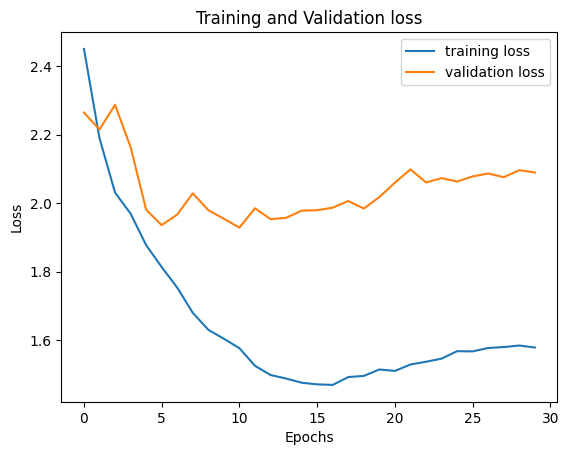

In [66]:
epochs = range(EPOCHS)
fig, ax = plt.subplots()
ax.plot(epochs,train_loss_per_epoch,label ='training loss')
ax.plot(epochs, val_loss_per_epoch, label = 'validation loss' )
ax.set_title('Training and Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
plt.show()

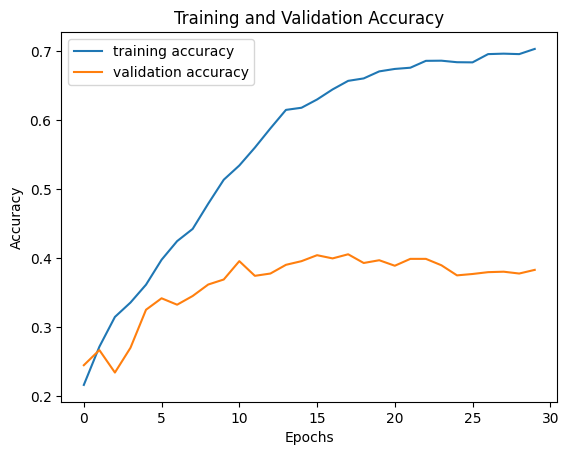

In [67]:
epochs = range(EPOCHS)
fig, ax = plt.subplots()
ax.plot(epochs,train_accuracy_list,label ='training accuracy')
ax.plot(epochs, valid_accuracy_list, label = 'validation accuracy' )
ax.set_title('Training and Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()
plt.show()

# Performance Metrics

In [68]:
v_pred_list =valid_pred.tolist()
# labels
type(v_pred_list)
# type(y_val)
# type(train_data['encoded_Author'].unique().tolist())

# target_names = [str(name) for name in train_data['encoded_Author'].unique().tolist()]
target_names = [str(name) for name in new_df['encoded_Author'].unique().tolist()]

# target_names

In [69]:
from sklearn.metrics import classification_report
print('classifiation report')
print(classification_report(y_val, v_pred_list,  target_names=target_names))
# A high precision score indicates that the model is good at avoiding false positives.
#A high recall score indicates that the model is good at avoiding false negatives.
# A high F1 score indicates that the model has good precision and recall.

classifiation report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        60
           1       0.28      0.28      0.28        60
           2       0.26      0.62      0.36        60
           3       0.40      0.33      0.36        60
           4       0.18      0.07      0.10        60
           5       0.43      0.38      0.41        60
           6       0.68      0.53      0.60        60
           7       0.42      0.47      0.44        60
           8       0.00      0.00      0.00        61
           9       0.42      0.31      0.36        61
          10       0.75      0.65      0.70        60
          11       0.17      0.13      0.15        60
          12       0.39      0.57      0.46        60
          13       0.38      0.44      0.41        61
          14       0.50      0.37      0.42        60
          15       0.47      0.45      0.46        60
          16       0.52      0.46      0.49        61
      

## Error Analysis

In [83]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels=None):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(20, 20))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels) 
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False) 
  plt.title("Normalized confusion matrix")
  plt.show()

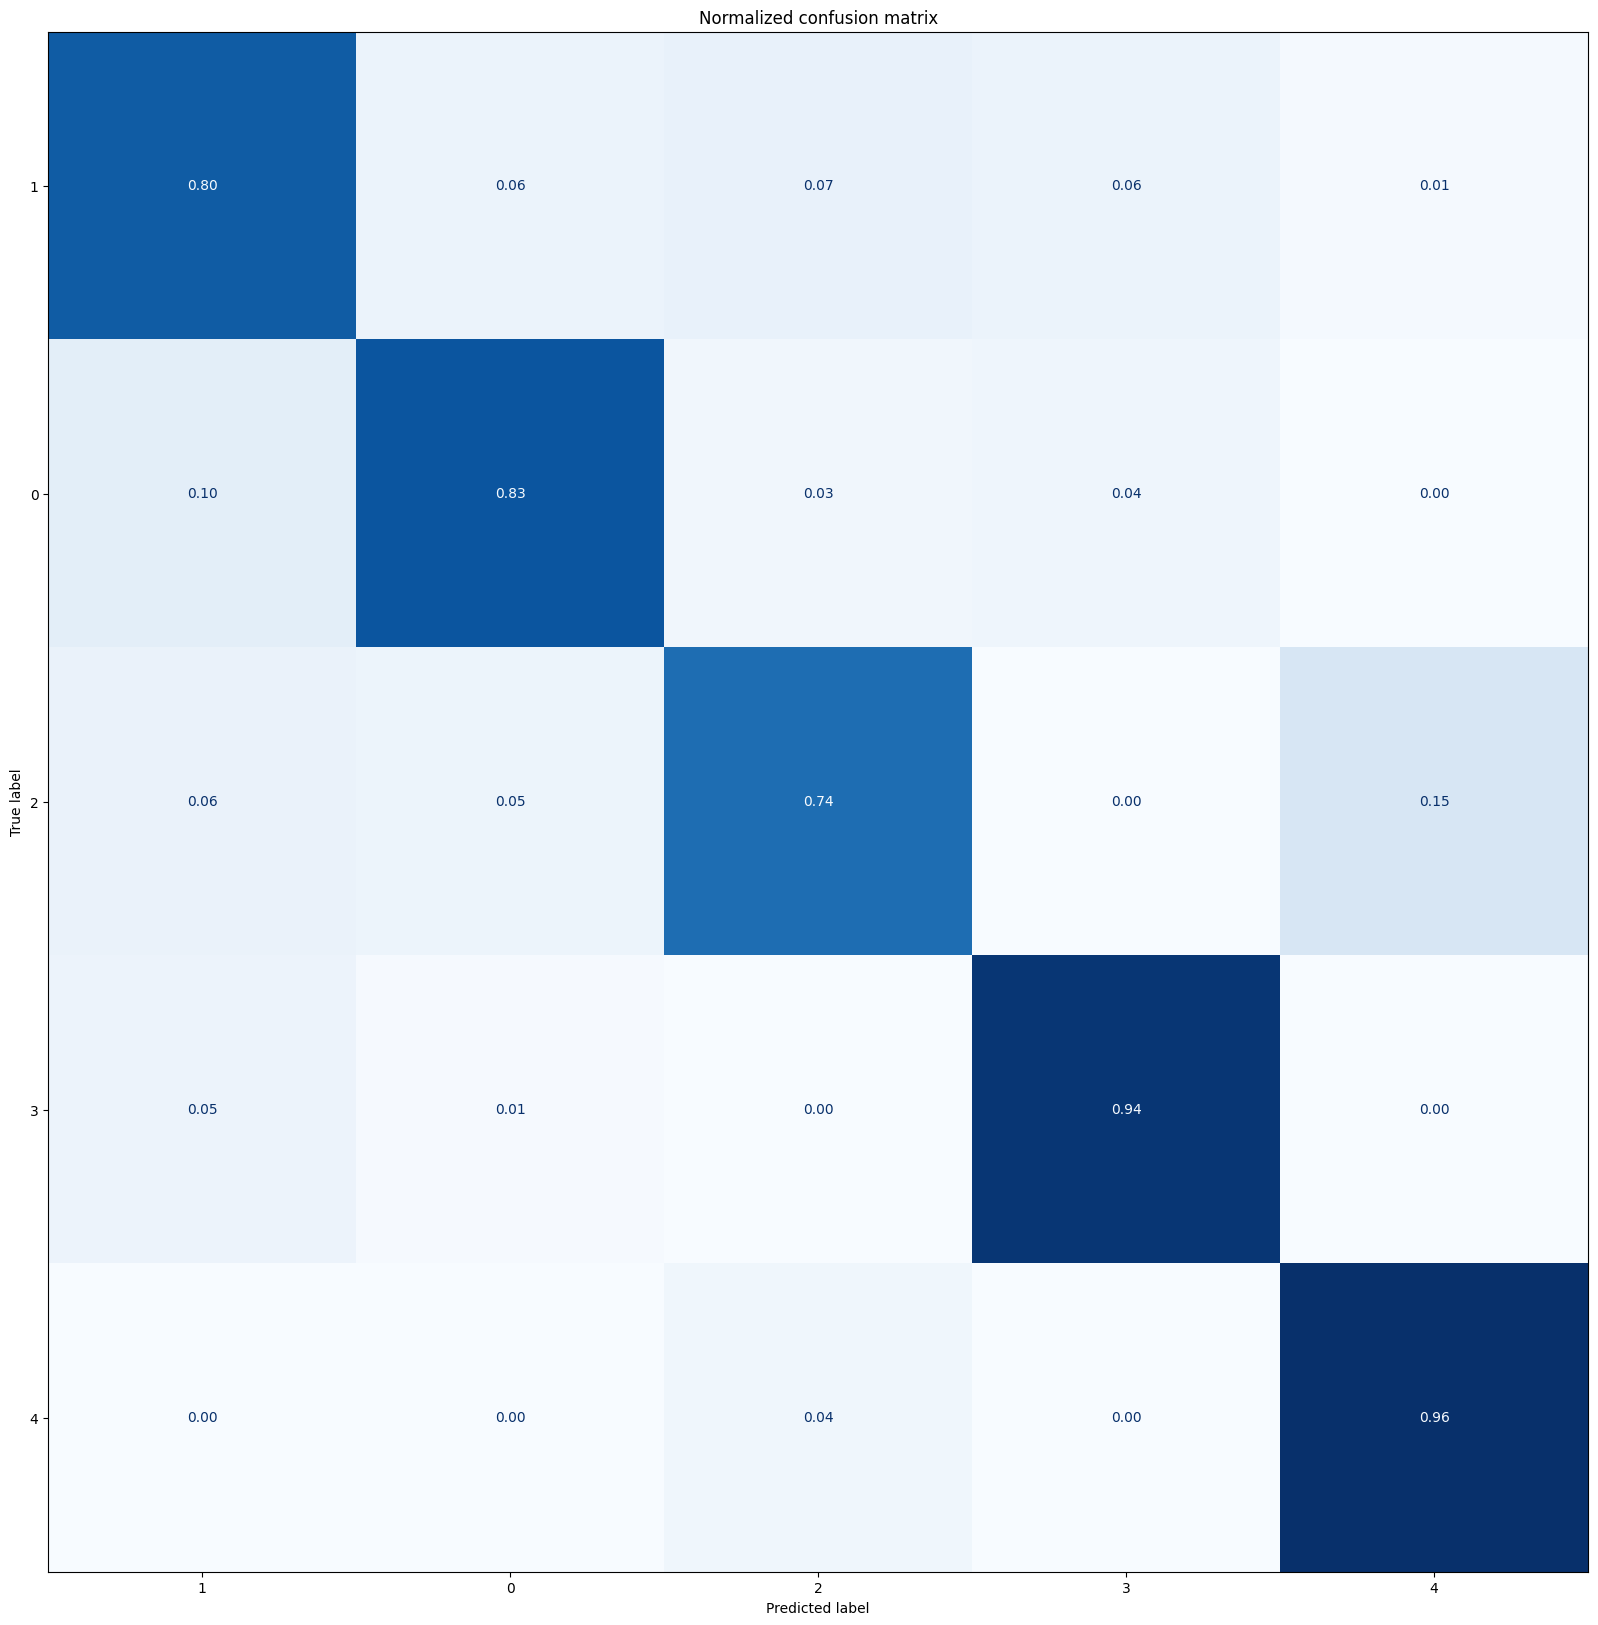

In [84]:
plot_confusion_matrix(v_pred_list,y_val,labels=target_names)


# Prediction

In [85]:
# def predict():
model.eval()
model.to(device)
test_pred = []
test_loss= 0
with torch.no_grad():
    for step_num, batch_data in tqdm(enumerate(test_dataloader)):
        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
        # input_embeds=model.get_input_embeddings().weight[input_ids.to('cuda')].clone().to('cuda')
        # print(input_embeds.shape)
        # print(len(input_ids[0]))
        # print(labels)
        output = model(input_ids=input_ids.to(device), attention_mask=att_mask.to(device), labels= labels.to(device))
        # output = model(attention_mask=att_mask.to('cuda'), inputs_embeds=input_embeds, labels= labels.to('cuda'))
        # print(output.logits.shape) torch.size([24,50])
        logits = torch.nn.functional.softmax(output.logits, dim=1)
        # print(len(logits.cpu().detach().numpy()[0]))
        loss = output.loss
        test_loss += loss.item()

        test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
test_pred = np.concatenate(test_pred)

0it [00:00, ?it/s]

In [86]:
len(test_pred)

1000

In [87]:
# test_labels = pd.DataFrame(data=(y_test) ,columns=['encoded-author', 'Text'])
classifications = pd.DataFrame({'Text': X_test, 'encoded-cluster': y_test})

In [89]:
classifications['pred'] = test_pred
# classifications.reset_index(level=0)

print(classifications[classifications['encoded-cluster']==classifications['pred']].shape)
classifications[classifications['encoded-cluster']==classifications['pred']][['Text', 'encoded-cluster','pred']].head(10)
classifications.reset_index(drop=True, level=0)

classifications.to_csv(r'distilbert_finetuned_c50_tfidf\finetuned_distilbert_c50_tfidf_pt25_testClassifications.csv')

(805, 3)


In [138]:
# load the saved model
saved_model_path = r"distilbert_finetuned_c50\distilbert_finetuned_c50_30.pt"
saved_model = torch.load(saved_model_path, map_location=torch.device('cpu'))["model_state_dict"]

# get the shape of the current model's classifier layer
current_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=N_labels)
current_weight_shape = current_model.classifier.weight.shape
current_bias_shape = current_model.classifier.bias.shape

# modify the saved model's classifier layer
saved_model["classifier.weight"] = saved_model["classifier.weight"][:current_weight_shape[0], :]
saved_model["classifier.bias"] = saved_model["classifier.bias"][:current_bias_shape[0]]

# load the modified saved model into the current model
current_model.to(device)
current_model.load_state_dict(saved_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.w

<All keys matched successfully>

In [34]:
# def predict(input_ids, att_masks, labels):
#     print("labels")
#     print(labels.shape)
#     input_ids = input_ids.long()
#     print(input_ids.shape)
#     # att_masks = torch.LongTensor(att_masks)
#     input_embeds=model.get_input_embeddings().weight[input_ids.to('cuda')].clone().to('cuda')
#     print(f"Embeds: {input_embeds.shape}")
#     _, outputs = model(attention_mask=att_masks.to('cuda'), inputs_embeds=input_embeds, labels= labels.to('cuda'))
#     print(f"Outputs: {outputs.shape}")
#     return outputs


In [35]:
# input_ids = torch.tensor([1, 2, 3])
# attention_mask = torch.tensor([1, 1, 1])
# input_ids_batch = input_ids.unsqueeze(0)
# attention_mask_batch = attention_mask.unsqueeze(0)
# output = model(input_ids=input_ids_batch.to(device), attention_mask=attention_mask_batch.to(device))
# print(input_ids, input_ids_batch, attention_mask, attention_mask_batch)

In [102]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(current_model, tokenizer, custom_labels=set(y_train))
word_attributions = cls_explainer(str(test_data['Text'][5]))

In [103]:
print(f"Predicted: {cls_explainer.predicted_class_name}, Actual: {test_data['true-author'][5]}")
#predicted starts at 0 so +1
print(f"Text: {test_data['Text'][5]}")

Predicted: 32, Actual: candidate00033
Text: ivorian port cocoa stocks stand at up to 175000 tonnes as arrivals trickle in at about 1000 tonnes a week but april and brisk may exports will reduce levels port sources said on friday


In [125]:
word_attributions
# 0.8503354796544661+0.27873767915291053
# a = ('a', 0.8249223962053632)
# b = ('b', 0.42957157340859525)
# c = [list(a), list(b)]
# c[-1][1] += 0.6
# c


[('ivo', 0.8503354796544661),
 ('##rian', 0.27873767915291053),
 ('port', -0.1188654885620636),
 ('cocoa', 0.3577461942507276),
 ('stocks', -0.09733293642750997),
 ('stand', -0.005759152771333129),
 ('at', -0.023178398349287786),
 ('up', -0.0492674625646151),
 ('to', 0.025184510543408374),
 ('1750', 0.03705272593285223),
 ('##00', 0.004325785875165788),
 ('tonnes', -0.0002998147717837385),
 ('as', 0.029644092362511757),
 ('arrivals', 0.03625936121094405),
 ('trickle', 0.04185875424283798),
 ('in', 0.01474569341115285),
 ('at', -0.037048514780748956),
 ('about', 0.03107033901112954),
 ('1000', 0.02438723194739538),
 ('tonnes', 0.0005257882330592027),
 ('a', 0.07710836771223854),
 ('week', 0.010488442709093613),
 ('but', 0.06694184986379269),
 ('april', 0.042312689780717665),
 ('and', 0.04585529411066016),
 ('brisk', -0.03630864300386607),
 ('may', 0.013412070857560033),
 ('exports', 0.06709764586735607),
 ('will', -0.02746489142177126),
 ('reduce', -0.0001615170129885031),
 ('levels', -

In [105]:
cls_explainer.visualize()

In [127]:
def get_full_words(text, word_attributions):
    # get list of tokens for the input text
    tokens = tokenizer.tokenize(text)

    # initialize list to store full words
    full_words = []
    full_scores = []
    # del word_attributions[0]
    # del word_attributions[-1]
    print(word_attributions)
    # iterate over word_attributions and map subwords to full words
    for i, attrib in enumerate(word_attributions):
        # attrib_list =list(attrib)
        if i == len(tokens): # ignore padding tokens
            break
        elif tokens[i].startswith("##"): # subword token
            #remove ## and add to last word of full_words
            full_words[-1] += tokenizer.convert_tokens_to_string([tokens[i]])[2:]
            # full_words[-1] = (full_words[-1] + tokenizer.convert_tokens_to_string([tokens[i]])[2:], full_words[-1] + attrib[1])
            # print(full_scores[-1], tokens[i])
            full_scores[-1] += attrib[1]
            # print( attrib[1])
            # print(full_words[-1][1] + attrib[1])
            # full_words [-1] = (full_words[-1][1] + attrib)
        else: # whole word token
            #add it as a separate word
            full_words.append(tokenizer.convert_tokens_to_string([tokens[i]]))#, attrib[1]))
            full_scores.append(attrib[1])
            # print(full_scores[-1])
            # print(full_words[-1])
    # print(full_words)
    # print(full_scores)
    return full_words, full_scores

In [129]:
full_words, full_scores = get_full_words(test_data['Text'][5], word_attributions)
full_word_attributions = list(zip(full_words, full_scores))
full_word_attributions

[('ivo', 0.8503354796544661), ('##rian', 0.27873767915291053), ('port', -0.1188654885620636), ('cocoa', 0.3577461942507276), ('stocks', -0.09733293642750997), ('stand', -0.005759152771333129), ('at', -0.023178398349287786), ('up', -0.0492674625646151), ('to', 0.025184510543408374), ('1750', 0.03705272593285223), ('##00', 0.004325785875165788), ('tonnes', -0.0002998147717837385), ('as', 0.029644092362511757), ('arrivals', 0.03625936121094405), ('trickle', 0.04185875424283798), ('in', 0.01474569341115285), ('at', -0.037048514780748956), ('about', 0.03107033901112954), ('1000', 0.02438723194739538), ('tonnes', 0.0005257882330592027), ('a', 0.07710836771223854), ('week', 0.010488442709093613), ('but', 0.06694184986379269), ('april', 0.042312689780717665), ('and', 0.04585529411066016), ('brisk', -0.03630864300386607), ('may', 0.013412070857560033), ('exports', 0.06709764586735607), ('will', -0.02746489142177126), ('reduce', -0.0001615170129885031), ('levels', -0.04273120113805885), ('port',

In [40]:
# for step_num, batch_data in tqdm(enumerate(test_dataloader)):
#     input_ids, att_mask, labels = [data.to(device) for data in batch_data]
import lime
from lime.lime_text import LimeTextExplainer

def predictor(text):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, max_length=MAX_LENGTH, padding='max_length', truncation=True,return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)#test_dataset.__getitem__(3)[0]
    input_ids_batch = input_ids#.unsqueeze(0)
    attn_mask = inputs['attention_mask']#test_dataset.__getitem__(3)[1].unsqueeze(0)
    attn_mask_batch = attn_mask#.unsqueeze(0)
    labels = torch.tensor([19])#.unsqueeze(0)
    with torch.no_grad():
        output = current_model(input_ids=input_ids_batch.to(device), attention_mask=attn_mask_batch.to(device), labels= labels.to(device))
        logits = output.logits
    logits = torch.nn.functional.softmax(logits, dim=1)
    print(type(logits.cpu().detach().numpy()))
    return logits.cpu().detach().numpy()

In [41]:
predictor(str(test_data['Text'][3]))
# test_data['true-author'][3]
# print(test_dataset.__getitem__(3))

<class 'numpy.ndarray'>


array([[0.00790534, 0.07066935, 0.0109354 , 0.01423673, 0.01305099,
        0.01405072, 0.01862618, 0.013124  , 0.01383873, 0.01535242,
        0.00943811, 0.01227968, 0.01186598, 0.16289397, 0.01587393,
        0.01162384, 0.0191293 , 0.01430193, 0.11802951, 0.01588851,
        0.01622673, 0.0183367 , 0.01309822, 0.01082746, 0.01088262,
        0.01366623, 0.01044145, 0.01127238, 0.02191918, 0.01354954,
        0.0129956 , 0.0101488 , 0.01143571, 0.01147893, 0.02193076,
        0.0117601 , 0.01275489, 0.01587012, 0.0127771 , 0.01105829,
        0.01477066, 0.01215464, 0.01213272, 0.01238701, 0.01188762,
        0.01855271, 0.01357093, 0.0227754 , 0.01372744, 0.01249544]],
      dtype=float32)

In [40]:
classes = train_data['Author'].unique()
explainer = LimeTextExplainer(class_names=classes)
exp_text =str(test_data['Text'][3])
exp = explainer.explain_instance(exp_text, predictor)#, labels=[4, 15])
exp

<class 'numpy.ndarray'>


ValueError: Found input variables with inconsistent numbers of samples: [5000, 1]

In [ ]:
from captum.attr import IntegratedGradients
# device = 'cpu'
ig = IntegratedGradients(model.to(device))
input_texts = test_data['Text'].tolist()[:5]  # assuming your test dataset has a 'text' column
tokens = tokenizer.batch_encode_plus(input_texts, return_tensors='pt', padding=True, truncation=True).to(device)

input_ids = tokens['input_ids']
input_ids = input_ids.cpu().long()
print(type(input_ids))
att_masks = tokens['attention_mask']
att_masks = att_masks.cpu().long()
print(type(att_masks))

def predict_proba(ids, masks):
    logits = model(ids, masks)[0]
    return torch.softmax(logits, dim=1)

# compute the predictions for the test dataset
predictions = predict_proba(input_ids, att_masks)

# compute the attributions using integrated gradients
for step_num, batch_data in tqdm(enumerate(test_dataloader)):
    input_ids, att_mask, labels = [data.to(device) for data in batch_data]
    attributions = ig.attribute((input_ids, att_masks), n_steps=50)

# # print the most important words for the first test example
# tokens = tokenizer.tokenize(input_texts[0])
# for i in attributions[0].nonzero(as_tuple=False).tolist():
#     print(tokens[i])

# # print the model's predictions for the first test example
# print(predictions[0])

In [61]:
# https://coderzcolumn.com/tutorials/artificial-intelligence/captum-for-pytorch-text-classification-networks
# https://captum.ai/tutorials/IMDB_TorchText_Interpret
from captum.attr import IntegratedGradients
from captum.attr import visualization
# predict()
input_text = test_texts[1]
inputs = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
# test_input = test_input_ids[0].unsqueeze(0).long()
print(f"Input :{input_ids.shape}")
# test_att = test_att_masks[0]#.long()
print(f"Att :{attention_mask.shape}")
target = test_y[0].unsqueeze(0)
print(type(target))
print(target.shape)

ig = IntegratedGradients(predict)
# predict(test_input_ids.to(device)[:21], test_att_masks.to(device)[:21])
attributions, delta = ig.attribute((input_ids.to(device), attention_mask.to(device), target.to(device)), target=target, return_convergence_delta=True)


Input :torch.Size([1, 73])
Att :torch.Size([1, 73])
<class 'torch.Tensor'>
torch.Size([1])


NameError: name 'predict' is not defined

In [47]:
print('classifiation report')
print(classification_report(test_pred, y_test,target_names=target_names))


classifiation report


NameError: name 'test_pred' is not defined

In [ ]:
plot_confusion_matrix(test_pred,y_test,labels=target_names)

In [ ]:
#Output misclassified text
test_df['pred'] = test_pred
test_df.reset_index(level=0)
print(test_df[test_df['label']!=test_df['pred']].shape)
test_df[test_df['label']!=test_df['pred']][['text','label','pred']].head(10)

# Gradient-Based Adversarial Attack

## FGSM Attack

In [49]:
# load the saved model
saved_model_path = r"distilbert_finetuned_c50\distilbert_finetuned_c50_30.pt"
saved_model = torch.load(saved_model_path, map_location=torch.device('cpu'))["model_state_dict"]

# get the shape of the current model's classifier layer
current_model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=N_labels)
current_weight_shape = current_model.classifier.weight.shape
current_bias_shape = current_model.classifier.bias.shape

# modify the saved model's classifier layer
saved_model["classifier.weight"] = saved_model["classifier.weight"][:current_weight_shape[0], :]
saved_model["classifier.bias"] = saved_model["classifier.bias"][:current_bias_shape[0]]

# load the modified saved model into the current model
current_model.load_state_dict(saved_model)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.w

<All keys matched successfully>

In [38]:
# saved_model.keys()
# saved_model['model_state_dict']

In [35]:
import torch
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the pretrained model and tokenizer
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)
# checkpoint = torch.load(r'distilbert_finetuned_c50\distilbert_finetuned_c50_30.pt')
# # #1e-6 -> 1e-5
# model.load_state_dict(checkpoint['model_state_dict'])

# Define a function to generate adversarial text using FGSM
# def fgsm_attack(input_text, epsilon, data_grad):
#     # Get the sign of the gradient
#     sign_data_grad = data_grad.sign()
#     # Create the perturbation vector
#     perturbed_input = input_text + epsilon * sign_data_grad
#     # Return the adversarial text
#     return perturbed_input
import torch.nn.functional as F

# def fgsm_attack(model, loss_fn, inputs_embeds, labels, epsilon=0.1):
#     # Set requires_grad attribute of tensor. Important for Attack
#     inputs_embeds.requires_grad_()
#     # Forward pass
#     outputs = model(inputs_embeds=inputs_embeds)
#     # Calculate loss
#     loss = loss_fn(outputs, labels)
#     # Calculate gradients
#     loss.backward()
#     # Create perturbed inputs
#     perturbed_inputs_embeds = inputs_embeds + epsilon * inputs_embeds.grad.sign()
#     # Return the perturbed inputs as a tensor
#     return perturbed_inputs_embeds.detach()

import torch.nn.utils.rnn as rnn_utils

def fgsm_attack(model, loss_fn, inputs_embeds, labels, epsilon=0.1):
    # inputs_embeds = torch.transpose(inputs_embeds, 0, 1)#.unsqueeze(0)  # add batch dimension
    inputs_embeds.requires_grad_()# = True
    print(f"Inputs embeds in fgsm: {inputs_embeds.shape}")
    outputs = model(inputs_embeds=inputs_embeds)
    
    _, predicted = torch.max(outputs.logits, 1)
    print(f"Output logit shapes: {outputs.logits.shape}")
    print(f"Predicted: {predicted.shape}")
    if predicted.item() == labels:
        loss = loss_fn(outputs.logits, torch.tensor([labels]))
        model.zero_grad()
        loss.backward()

        inputs_embeds_grad = inputs_embeds.grad

        # Add perturbation
        inputs_embeds_adv = inputs_embeds + epsilon * torch.sign(inputs_embeds_grad)
        print(f"INPUTS EMBEDS ADV: {inputs_embeds_adv}")
        # Pad inputs_embeds_adv to the expected length of the model
        inputs_embeds_adv = rnn_utils.pad_sequence([inputs_embeds_adv.squeeze(0)], batch_first=True)

        # Get model prediction on perturbed input
        outputs_adv = model(inputs_embeds=inputs_embeds_adv)

        # Get perturbed text
        perturbed_text = tokenizer.decode(torch.argmax(inputs_embeds_adv.squeeze(), dim=1).tolist())

        # Compute loss on perturbed input and backpropagate
        loss_adv = loss_fn(outputs_adv, torch.tensor([labels]))
        model.zero_grad()
        loss_adv.backward()

        return perturbed_text
    else:
        return None


In [41]:
model.to(device)
model.distilbert.embeddings.to(device)

Embeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [42]:
len(test_texts[0])
# test_texts[0]

205

In [43]:
# Define the input text and label
input_text = test_texts[1]#"This is a positive text"
# label = 14#torch.tensor([1]).to(device)
# inputs_embeds = input_text['input_embeds']
# num_classes = 50
# label_tensor = torch.zeros(num_classes)
# label_tensor[label] = 1

model.to('cpu')
# Convert the input text to a tensor
# input_ids = torch.LongTensor(tokenizer.encode(input_text, add_special_tokens=True)).unsqueeze(0).to(device)
# inputs_embeds = model.distilbert.embeddings.word_embeddings(torch.tensor(input_ids))
# Convert the text to input embeddings
input_ids = torch.tensor(tokenizer.encode(input_text, add_special_tokens=True)).unsqueeze(0)
# input_ids = input_ids.transpose(1, 0)  # shape [sequence_length, 1]

print(f"Inputs ids: {input_ids.shape}")
# inputs_embeds = model.distilbert.embeddings.word_embeddings(torch.tensor(input_ids)).to('cpu')
inputs_embeds =model.distilbert.get_input_embeddings().weight[input_ids].clone()
inputs_embeds = torch.nn.Parameter(input_embeds.unsqueeze(0), requires_grad=True)
# inputs_embeds = inputs_embeds.transpose(1, 0)
print(f"Inputs embeds initial: {inputs_embeds.shape}")
# Set the label to a target class
target_label = torch.tensor([37]).to(device)
# Generate the perturbed text using the FGSM attack
perturbed_inputs = fgsm_attack(model, F.cross_entropy, inputs_embeds, target_label, epsilon=0.1)
if perturbed_inputs is None:
    print("Adversarial example not generated.")
else:
    perturbed_ids = torch.argmax(perturbed_inputs, dim=-1)
    perturbed_text = tokenizer.batch_decode(perturbed_ids)
    print("Perturbed text: ", perturbed_text)

# Convert the perturbed embeddings back to text
# perturbed_ids = torch.argmax(perturbed_inputs, dim=-1)
# perturbed_text = tokenizer.decode(perturbed_ids.tolist()[1:-1])

# print("Original text:", input_text)
# print("Perturbed text:", perturbed_text)

Inputs ids: torch.Size([1, 42])


NameError: name 'input_embeds' is not defined

In [44]:
input_shape = tokenizer([input_text], return_tensors='pt')['input_ids'].shape
input_shape

torch.Size([1, 42])

In [45]:
def fgsm_attack(model, loss_fn, text, labels, epsilon=0.1):
    model.to(device)
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True)).unsqueeze(0).to(device)

    input_embeds = model.distilbert.embeddings.word_embeddings(input_ids.to(device))
    input_embeds = torch.nn.Parameter(input_embeds, requires_grad=True)
    input_embeds = input_embeds.to(device)
    print(input_embeds.shape)
    outputs = model(inputs_embeds=input_embeds)
    loss = loss_fn(outputs.logits, labels)
    model.zero_grad()
    loss.backward()
    
    perturbed_inputs = input_embeds + epsilon * input_embeds.grad.sign()
    perturbed_inputs = torch.clamp(perturbed_inputs, 0, 1)
    
    return perturbed_inputs


In [46]:
perturbed_inputs = fgsm_attack(model, F.cross_entropy, input_text, torch.tensor([37]).to(device))

torch.Size([1, 42, 768])


In [47]:
perturbed_inputs

tensor([[[0.1390, 0.0000, 0.0792,  ..., 0.0000, 0.1230, 0.1238],
         [0.0537, 0.0000, 0.1017,  ..., 0.0000, 0.0890, 0.0528],
         [0.0000, 0.0000, 0.0032,  ..., 0.0079, 0.0151, 0.0925],
         ...,
         [0.0527, 0.0609, 0.0413,  ..., 0.0221, 0.0000, 0.0000],
         [0.0000, 0.0737, 0.0000,  ..., 0.0000, 0.0213, 0.0273],
         [0.0000, 0.0000, 0.0901,  ..., 0.0765, 0.1071, 0.0000]]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [48]:
perturbed_ids = perturbed_inputs.argmax(dim=-1).squeeze().tolist()
perturbed_ids

[121,
 419,
 343,
 717,
 376,
 620,
 22,
 317,
 670,
 121,
 419,
 541,
 419,
 419,
 540,
 175,
 419,
 426,
 419,
 419,
 71,
 150,
 121,
 389,
 482,
 311,
 419,
 91,
 573,
 159,
 132,
 546,
 202,
 216,
 319,
 311,
 419,
 245,
 766,
 53,
 356,
 77]

In [49]:
perturbed_text = tokenizer.decode(perturbed_ids, clean_up_tokenization_spaces=True)
perturbed_text

'[unused116] [unused414] [unused338] [unused712] [unused371] [unused615] [unused21] [unused312] [unused665] [unused116] [unused414] [unused536] [unused414] [unused414] [unused535] [unused170] [unused414] [unused421] [unused414] [unused414] [unused70] [unused145] [unused116] [unused384] [unused477] [unused306] [unused414] [unused90] [unused568] [unused154] [unused127] [unused541] [unused197] [unused211] [unused314] [unused306] [unused414] [unused240] [unused761] [unused52] [unused351] [unused76]'

In [51]:
!pip install captum

     ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
     ---- ----------------------------------- 0.2/1.3 MB 4.6 MB/s eta 0:00:01
     --------------- ------------------------ 0.5/1.3 MB 5.3 MB/s eta 0:00:01
     --------------------------------- ------ 1.1/1.3 MB 7.8 MB/s eta 0:00:01
     ---------------------------------------  1.3/1.3 MB 8.3 MB/s eta 0:00:01
     ---------------------------------------- 1.3/1.3 MB 6.4 MB/s eta 0:00:00


In [56]:
import torch
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization

# Define your model and tokenizer
# model = ...
# tokenizer = ...
model.to(device)
model.eval()
# Define your input text
input_text = test_texts[1]#"This is a positive text"

# Tokenize your input text and convert it to tensor
# input_ids = torch.tensor([tokenizer.encode(input_text, add_special_tokens=True)])
inputs = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    max_length=MAX_LENGTH,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']
input_shape = input_ids.shape
print(input_shape)
print(attention_mask.shape)
# Define a reference token for attribution
reference_token_id = tokenizer.pad_token_id
reference_tokens = torch.zeros_like(input_ids)
reference_tokens = reference_tokens.view(input_ids.shape[0], -1)
print(reference_tokens.shape)
# Compute saliency map using Layer Integrated Gradients
# output = model(input_ids.to(device), attention_mask=attention_mask.to(device))
# logits = output.logits
target = torch.tensor([0]).to(device)
lig = LayerIntegratedGradients(model.distilbert, model.distilbert.embeddings)

# attributions, delta = lig.attribute(input_ids.to(device), baselines=reference_tokens.to(device), target=target.to(device))
attributions, delta = lig.attribute(inputs=input_ids.to(device), baselines=reference_tokens.to(device), additional_forward_args=attention_mask.to(device), target=target, return_convergence_delta=True)

attributions = attributions.sum(dim=-1)

# Visualize saliency map
tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())
visualization.visualize_text([attributions.squeeze().tolist()], tokens)

torch.Size([1, 73])
torch.Size([1, 73])
torch.Size([1, 73])


AttributeError: 'BaseModelOutput' object has no attribute 'shape'

In [59]:
type(model.distilbert.embeddings)
import captum
help(captum)


Help on package captum:

NAME
    captum

PACKAGE CONTENTS
    _utils (package)
    attr (package)
    concept (package)
    influence (package)
    insights (package)
    log (package)
    metrics (package)
    module (package)
    robust (package)

VERSION
    0.6.0

FILE
    c:\users\sadai\desktop\authorprediction\pt_lm\lib\site-packages\captum\__init__.py




In [71]:
type(input_ids)

torch.Tensor